# Лабораторная работа 3

**Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM
from scipy.stats import shapiro, spearmanr, pearsonr

**Задание №1**

Воспользуемся данными npk, иллюстрирующими влияние применения различных удобрений на урожайность гороха (yield). трехфакторный дисперсионный анализ, где зависимая переменная - это урожайность (yield), а три фактора - типы удобрений (N, P, K). После проведения данного анализа вы получите три значения p - уровня значимости, сделайте вывод о значимости каждого из факторов.

In [2]:
data_npk = pd.read_csv('info-folder/data/npk.csv', sep=",", skiprows=1)
data_npk.columns = ["id", "block", "N", "P", "K", "extra", "yield"]
data_npk = data_npk.drop(columns=["extra"])
data_npk.rename(columns={'yield': 'yield_value'}, inplace=True)
data_npk = data_npk.apply(pd.to_numeric, errors='coerce')

# Преобразование факторов в категориальные переменные
data_npk["N"] = data_npk["N"].astype("category")
data_npk["P"] = data_npk["P"].astype("category")
data_npk["K"] = data_npk["K"].astype("category")

# Упрощенная модель ANOVA 
model = ols('yield_value ~ C(N) + C(P) + C(K)', data=data_npk).fit()

# Выполнение ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Вывод результатов
anova_table

,sum_sq,df,F,PR(>F)
C(N),340.735580,5.0,3.065196,0.042050
C(P),169.338536,1.0,7.616695,0.014594
C(K),6.139712,1.0,0.276159,0.606912
Residual,333.488229,15.0,NaN,NaN


По представленной таблице ANOVA:

1. **Фактор \( C(N) \):**
   - \(PR(>F) = 0.042050 \), что меньше уровня значимости \( alpha = 0.05 \).
   - Это означает, что фактор \( N \) оказывает статистически значимое влияние на урожайность.

2. **Фактор \( C(P) \):**
   - \((PR(>F) = 0.014594 \), также меньше \( alpha = 0.05 \).
   - Фактор \( P \) также является статистически значимым.

3. **Фактор \( C(K) \):**
   - \((PR(>F) = 0.606912 \), что значительно больше \( alpha = 0.05 \).
   - Это указывает на отсутствие статистически значимого влияния фактора \( K \) на урожайность.

#### Вывод:
Факторы \( N \) и \( P \) оказывают значительное влияние на урожайность, в то время как фактор \( K \) не оказывает значимого влияния.  

**Задание №2**

Проведите однофакторный дисперсионный анализ на встроенных данных iris. Зависимая переменная - ширина чашелистика (Sepal.Width), независимая переменная - вид (Species). Затем проведите попарные сравнения видов. Какие виды статистически значимо различаются по ширине чашелистика (p < 0.05)?

In [3]:
iris_data = pd.read_csv('info-folder/data/Iris.csv')

iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Переименую столбцы для упрощения обработки
iris_data.rename(columns={"SepalWidthCm": "Sepal_Width", "Species": "Species"}, inplace=True)

# Выполните односторонний дисперсионный анализ
model = ols('Sepal_Width ~ Species', data=iris_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Проведите HSD Tukey для парных сравнений.
tukey_results = pairwise_tukeyhsd(iris_data["Sepal_Width"], iris_data["Species"], alpha=0.05)

anova_table, tukey_results.summary()

(           sum_sq     df          F        PR(>F)
 Species   10.9776    2.0  47.364461  1.327917e-16
 Residual  17.0350  147.0        NaN           NaN,
 <class 'statsmodels.iolib.table.SimpleTable'>)

Результаты однофакторного дисперсионного анализа (ANOVA):

F-статистика: 47.36
p-значение: 1.33×10^−16
 
Это показывает, что различия между видами статистически значимы (p < 0.05).

Теперь проведем попарные сравнения видов с использованием теста Тьюки (Tukey HSD), чтобы определить, какие виды статистически значимо различаются. 

In [5]:
# Extracting Tukey's HSD results into a DataFrame for better clarity
tukey_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])

tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Iris-setosa,Iris-versicolor,-0.648,0.000,-0.8092,-0.4868,True
1,Iris-setosa,Iris-virginica,-0.444,0.000,-0.6052,-0.2828,True
2,Iris-versicolor,Iris-virginica,0.204,0.009,0.0428,0.3652,True


Все три вида (Iris-setosa,Iris-versicolor, Iris-virginica) статистически значимо различаются друг от друга по ширине чашелистика (Sepal.Width).

**Задание №3**

В этой задаче вам дан набор данных («Pilluikin.csv»), в котором представлена информация о температуре нескольких пациентов, которые лечатся разными таблетками и у разных врачей. Проведите
однофакторный дисперсионный анализ с повторными измерениями: влияние типа таблетки (pill) на температуру (temperature) с учётом испытуемого (patient). Каково p-value для влияния типа
таблеток на температуру?

In [6]:
pillulkin_data = pd.read_csv("info-folder/data/Pillulkin.csv")

pillulkin_data.head()

,temperature,pill,doctor,patient
0,39.330552,A,Aibolit,1
1,40.748766,B,Aibolit,1
2,39.339130,A,Aibolit,2
3,38.204377,B,Aibolit,2
4,36.997569,A,Aibolit,3


In [7]:
# Агрегирование данных путем определения средней температуры для каждой комбинации пациент-таблетка.
pillulkin_data_aggregated = pillulkin_data.groupby(['patient', 'pill'], as_index=False)['temperature'].mean()

# Снова выполните повторные измерения ANOVA с агрегированными данными.
rm_anova_aggregated = AnovaRM(data=pillulkin_data_aggregated, depvar='temperature', subject='patient', within=['pill'])
rm_anova_results_aggregated = rm_anova_aggregated.fit()

rm_anova_results_aggregated.summary()

,F Value,Num DF,Den DF,Pr > F
pill,0.0510,1.0000,9.0000,0.8264


Результаты однофакторного дисперсионного анализа с повторными измерениями:

- F-значение: 0.051
- p-value: 0.8264

Значение 0.8264 превышает стандартный порог значимости 0.05, что указывает на отсутствие статистически значимых различий в температуре между различными типами таблеток.

**Задание №4**

Теперь Вашей задачей будет провести двухфакторный дисперсионный анализ с повторными измерениями: влияние факторов doctor, влияние фактора pill и их взаимодействие на temperature. Учтите 
обе внутригрупповые переменные: и тот факт, что один и тот же больной принимает разные таблетки, и тот факт, что один и тот же больной лечится у
разных врачей! Каково F-значение для взаимодействия факторов доктора (doctor) и типа таблеток (pill)?

In [8]:
# Выполняем двусторонние повторные измерения ANOVA
# Включая как «doctor», так и «pill» как внутрисубъектных факторов
rm_anova_two_way = AnovaRM(
    data=pillulkin_data,
    depvar='temperature',
    subject='patient',
    within=['pill', 'doctor']
)
rm_anova_two_way_results = rm_anova_two_way.fit()

# Извлечение значения F для взаимодействия между «doctor» и «pill»
interaction_f_value = rm_anova_two_way_results.anova_table.loc['pill:doctor', 'F Value']


rm_anova_two_way_results.summary(), interaction_f_value

(<class 'statsmodels.iolib.summary2.Summary'>
 """
                  Anova
             F Value Num DF Den DF Pr > F
 ----------------------------------------
 pill         0.0510 1.0000 9.0000 0.8264
 doctor       3.1132 1.0000 9.0000 0.1115
 pill:doctor  0.1458 1.0000 9.0000 0.7114
 
 """,
 np.float64(0.14583148471309737))

Результаты двухфакторного дисперсионного анализа с повторными измерениями:

- F-значение для взаимодействия факторов "doctor" и "pill": 0.146

Таким образом, взаимодействие между доктором и типом таблетки не является статистически значимым (p > 0.05).

**Задание №5**

Напишите функцию outliers.rm, которая находит и удаляет выбросы. Для обнаружения выбросов воспользуемся самым простым способом, с которым вы не раз встречались, используя график Box plot.
Выбросами будем считать те наблюдения, которые отклоняются от 1 или 3 квартиля больше чем на 1,5 * IQR, где IQR - межквартильный размах. На вход функция получает числовой вектор x. Функци 
должна возвращать модифицированный вектор x с удаленными выбросами.

In [9]:
def outliers_rm(x):
    """
    Удаление выбросов из числового вектора на основе правила 1,5 * IQR.
    
    Parameters:
    x (array-like): Numerical vector (list, array, or Series).
    
    Returns:
    np.array: Модифицированный вектор с удаленными выбросами.
    """
    # Преобразование ввода в массив NumPy
    x = np.array(x)
    
    # Рассчитываем Q1, Q3, and IQR
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    
    # Определение нижней и верхней границы для невыбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Удаление выбросов
    filtered_x = x[(x >= lower_bound) & (x <= upper_bound)]
    
    return filtered_x

In [10]:
# Генерация рандомных значений
np.random.seed(42)
x = np.concatenate((np.random.normal(loc=50, scale=10, size=20), [0, 100]))

# Применение функции outliers_rm для удаления выбросов
filtered_x = outliers_rm(x)
x, filtered_x

(array([ 54.96714153,  48.61735699,  56.47688538,  65.23029856,
         47.65846625,  47.65863043,  65.79212816,  57.67434729,
         45.30525614,  55.42560044,  45.36582307,  45.34270246,
         52.41962272,  30.86719755,  32.75082167,  44.37712471,
         39.8716888 ,  53.14247333,  40.91975924,  35.87696299,
          0.        , 100.        ]),
 array([54.96714153, 48.61735699, 56.47688538, 65.23029856, 47.65846625,
        47.65863043, 65.79212816, 57.67434729, 45.30525614, 55.42560044,
        45.36582307, 45.34270246, 52.41962272, 30.86719755, 32.75082167,
        44.37712471, 39.8716888 , 53.14247333, 40.91975924, 35.87696299]))

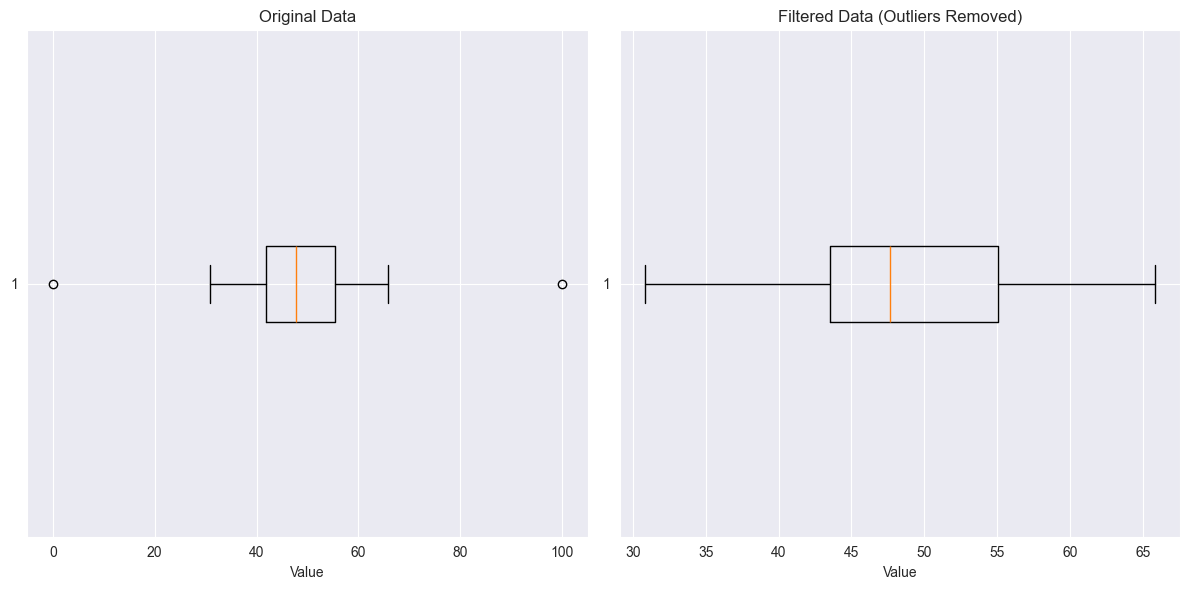

In [11]:
plt.figure(figsize=(12, 6))

# Box plot для оригинальных данных
plt.subplot(1, 2, 1)
plt.boxplot(x, vert=False)
plt.title('Original Data')
plt.xlabel('Value')
plt.grid(True)

# Box plot для отфильтрованных данных
plt.subplot(1, 2, 2)
plt.boxplot(filtered_x, vert=False)
plt.title('Filtered Data (Outliers Removed)')
plt.xlabel('Value')
plt.grid(True)

plt.tight_layout()
plt.show()

На графиках представлены **данные до и после удаления выбросов** с помощью правила 1.5 * IQR.

### **1. Левый график (Original Data):**
- Это исходные данные, где:
  - Видна их основная масса, расположенная примерно в диапазоне от 30 до 70.
  - Однако, есть два значения (выбросы) далеко за пределами основной группы: **0** (сильно ниже основного диапазона) и **100** (сильно выше).
  - Эти выбросы нарушают "симметрию" и могут исказить статистические выводы.

### **2. Правый график (Filtered Data):**
- Здесь показаны данные после удаления выбросов:
  - Значения 0 и 100 были удалены, так как они находятся за пределами границ, определённых правилом 1.5 * IQR.
  - Оставшиеся данные теперь более однородны, сосредоточены вокруг центрального диапазона.

### **Механика удаления:**
- Правило 1.5 * IQR (межквартильный размах) вычисляет "границы нормальных значений":
  - Нижняя граница: \( Q1 - 1.5 \times IQR \)
  - Верхняя граница: \( Q3 + 1.5 \times IQR \)
- Любое значение за пределами этих границ считается выбросом и удаляется.

**Задание №6**

Напишите функцию smart_cor, которая получает на вход dataframe с двумя количественными переменными. Проверьте с помощью теста Шапиро- Уилка, что данные в обеих переменных принадлежат 
нормальному распределению.
Если хотя бы в одном векторе распределение переменной отличается от нормального (p - value меньше 0.05), то функция должна возвращать коэффициент корреляции Спирмена. (Числовой вектор из 
одного элемента).
Если в обоих векторах распределение переменных от нормального значимо не отличается, то функция должна возвращать коэффициент корреляции Пирсона.

In [12]:
def smart_cor(dataframe):
    """
    Рассчитать коэффициент корреляции между двумя количественными переменными в кадре данных.
    
    - Если данные в любом столбце не распределены нормально (критерий Шапиро-Уилка, p < 0,05), 
      вернуть коэффициент корреляции Спирмена.
    - Если оба столбца нормально распределены, верните коэффициент корреляции Пирсона.
    
    Parameters:
    dataframe (pd.DataFrame): A dataframe ровно с двумя числовыми столбцами.

    Returns:
    float: коэффициент корреляции (Спирмена или Пирсона).
    """
    if dataframe.shape[1] != 2:
        raise ValueError("Input dataframe must have exactly two numeric columns.")
    
    # Извлечение двух переменных
    col1, col2 = dataframe.iloc[:, 0], dataframe.iloc[:, 1]
    
    # Выполнение тестов Шапиро-Уилка на нормальность
    p_val_col1 = shapiro(col1).pvalue
    p_val_col2 = shapiro(col2).pvalue
    
    # Определение, какую корреляцию использовать на основе нормальности
    if p_val_col1 < 0.05 or p_val_col2 < 0.05:
        # По крайней мере одна переменная не является нормально распределенной -> Спирмен
        print("Используется Spearmanr")
        correlation, _ = spearmanr(col1, col2)
    else:
        # Обе переменные имеют нормальное распределение -> Пирсон
        print("Используется Pearsonr")
        correlation, _ = pearsonr(col1, col2)
    
    return correlation

In [13]:
np.random.seed(42)
df = pd.DataFrame({
    'x': np.random.normal(size=100),
    'y': np.random.normal(size=100)
})

correlation_result = smart_cor(df)
correlation_result

Используется Pearsonr


np.float64(-0.13642221217000253)

In [14]:
np.random.seed(42)
df = pd.DataFrame({
    'x': np.random.normal(size=100),
    'y': np.random.binomial(n=20, p=0.5, size=100)
})

correlation_result = smart_cor(df)
correlation_result

Используется Spearmanr


np.float64(0.11868316860608825)

#### **Тест Шапиро-Уилка**
Тест Шапиро-Уилка используется для проверки гипотезы о том, что данные имеют нормальное распределение.

Нулевая гипотеза (H₀): Данные имеют нормальное распределение.
Альтернативная гипотеза (H₁): Данные не имеют нормального распределения.
Результат:
- Если 𝑝-значение ≥ 0.05, мы не отвергаем нулевую гипотезу — данные нормально распределены.
- Если 𝑝-значение < 0.05, мы отвергаем нулевую гипотезу — данные существенно отличаются от нормального распределения.

---

#### **Коэффициент корреляции Пирсона (Pearson)**
- **Что измеряет:** Линейную зависимость между двумя количественными переменными.
- **Диапазон:** От -1 до +1.
  - \( +1 \): Идеальная положительная линейная зависимость.
  - \( -1 \): Идеальная отрицательная линейная зависимость.
  - \( 0 \): Отсутствие линейной зависимости.
- **Условие применения:** Переменные должны быть количественными и нормально распределёнными.

---

#### **Коэффициент корреляции Спирмена (Spearman)**
- **Что измеряет:** Монотонную зависимость между двумя переменными (не обязательно линейную).
- **Диапазон:** Также от -1 до +1.
  - \( +1 \): Полная монотонная положительная зависимость.
  - \( -1 \): Полная монотонная отрицательная зависимость.
  - \( 0 \): Отсутствие монотонной зависимости.
- **Условие применения:** Подходит для числовых или порядковых данных. Используется, если данные не нормально распределены или имеют выбросы.

#### Основная идея:
- Переменные заменяются их рангами (позициями в отсортированном списке), после чего рассчитывается корреляция Пирсона для рангов.

---

#### **Когда использовать Пирсона или Спирмена?**

- **Пирсон**:
  - Линейные зависимости.
  - Нормальное распределение данных.
  - Отсутствие значительных выбросов.
  
- **Спирмен**:
  - Нелинейные (но монотонные) зависимости.
  - Данные, которые не соответствуют нормальному распределению.
  - Данные с выбросами.